# Failure Mode Demonstration Notebook

A notebook to demonstrate some of the features of the Failure Mode class

Author: gavin.treseder@essentialenergy.com.au

In [5]:
#  Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

import plotly.express as px
from reliability.Fitters import Fit_Weibull_3P

In [6]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition
from pof.task import *

fm = FailureMode().set_demo()

## Single timeline
Generate a single timeline to show the state of the failure mode, its condition and the days until a task is triggered over time.

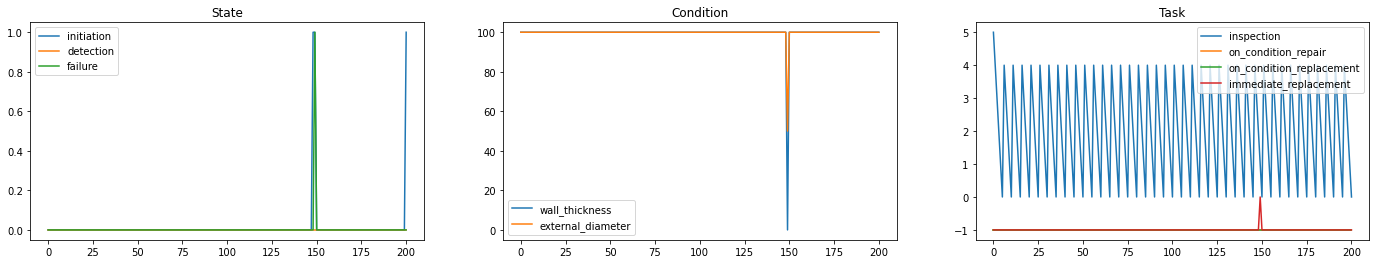

In [7]:
timeline = fm.sim_timeline(200, verbose=False)
fm.plot_timeline()

In [8]:
list(timeline)

['time',
 'initiation',
 'wall_thickness',
 'external_diameter',
 'failure',
 'inspection',
 'detection',
 'on_condition_repair',
 'on_condition_replacement',
 'immediate_replacement']

The simulation above assumes that the failure mode is in perfect condition while the simulation below starts with some accumulated damage.

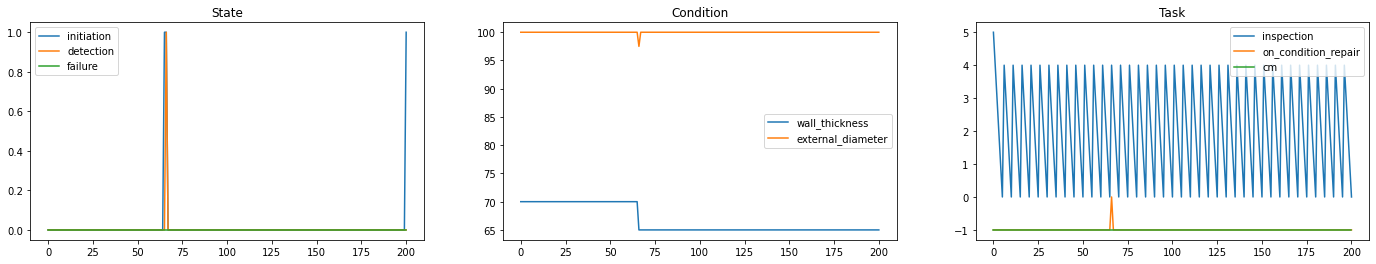

In [4]:
fm._initiated = True
fm.conditions['wall_thickness'].set_condition(70)
fm.sim_timeline(200)
fm.plot_timeline()

## Maintenance Strategy

The maintenance strategy...

In [8]:
fm = FailureMode().set_demo()

fm.conditions['wall_thickness'] = Condition(100, 0, 'linear', [-5])
fm.tasks['inspection'].p_effective = 1

fm.reset()

fm.mc_timeline(t_end=200, n_iterations=1000)

df = fm.expected_risk_cost_df()

fig = px.area(df, x="time", y="cost", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 1000/1000 [00:04<00:00, 231.99it/s]


In [9]:
fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error    Lower CI     Upper CI
Parameter                                                         
Alpha          626.637392      163.144314  376.189766  1043.820052
Beta             1.729187        0.245756    1.308781     2.284634
Gamma           89.005202       16.895326   61.353153   129.120113
Log-Likelihood: -420.47582130093673


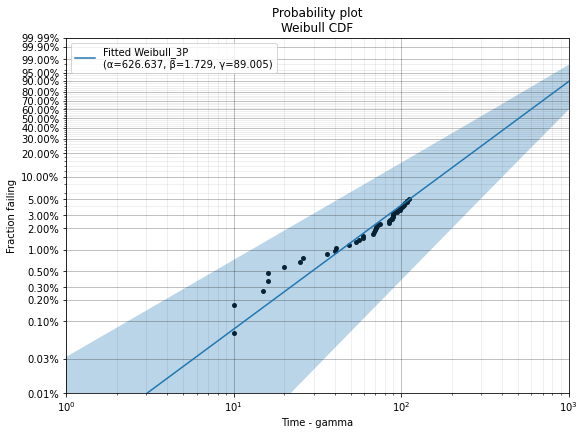

In [10]:
t_failures = []
for timeline in fm._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored);

## Condition

In [11]:
mean = np.array([fm._timelines[x]['wall_thickness'] for x in fm._timelines]).mean(axis=0)
sd = np.array([fm._timelines[x]['wall_thickness'] for x in fm._timelines]).std(axis=0)

upper = mean + sd
lower = mean - sd

upper[upper > 100] = 100
lower[lower < 0] = 0



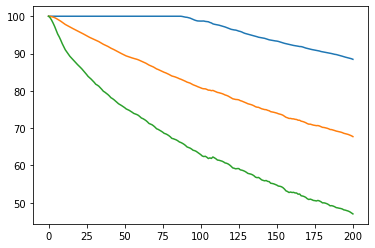

In [12]:

import plotly.graph_objects as go

fig = go.Figure()

def update_condition_fig(*args):
    """ Updates the condition figure"""

    ecu = comp.expected_condition

    for cond in comp.fm.conditions:

        # Format the data for plotting
        time = np.linspace(0,200,201, dtype=int)
        x = np.append(time,time[::-1])
        y = np.append(upper, lower[::-1])

        # Add the boundary
        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            fill='toself',
            fillcolor='rgba(231,107,243,0.2)',
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name='Ideal',
        ))
        fig.add_trace(go.Scatter(
            x=time, y=mean,
            line_color='rgb(0,100,80)',
            name='Fair',
        ))

        #fig.update_traces(mode='lines')

        return fig

fig.show()

<AxesSubplot:>

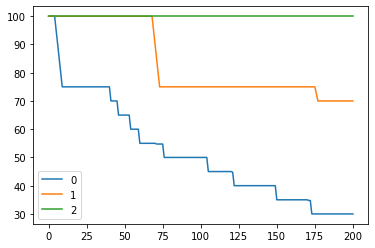

In [13]:
pd.DataFrame(np.percentile([fm._timelines[x]['wall_thickness'] for x in fm._timelines], q = [5,50,95], axis = 0)).T.plot()

In [12]:
a = np.linspace(0,10,11)

np.percentile(a, q = [0,50, 90])

array([0., 5., 9.])

In [10]:
t_interval = dict()
risk = dict()
cost = dict()
fm.reset()

for i in range(1,10, 1):

    # Set t_interval
    fm.tasks['inspection'].t_interval = i
    
    fm.mc_timeline(t_end=100, n_iterations=1000)

    cost[i] = fm._expected_cost()
    cost[i]['inspection_interval'] = i

    # Reset fm

    fm.reset()

100%|██████████| 1000/1000 [00:03<00:00, 266.77it/s]


In [11]:
df_plot = pd.DataFrame(cost).T

df_plot = pd.melt(df_plot, id_vars=['inspection_interval'], var_name = 'source', value_name = 'cost')

fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
fig.show()

In [10]:
# Dists

# Impacts



# Tasks
scheduled_inspection = Inspection(t_interval=10)

scheduled_inspection.set_params(
        t_interval = 5,
        t_delay = 20,
        p_effective = 0.9,
        state_triggers = dict(),

        condition_triggers = dict(
            wall_thickness = dict(
                lower = 0,
                upper = 90,
            ),
        ),

        state_impacts = dict( 
            detection = True,
        ),

        condition_impacts = dict(
            wall_thickness = dict(
                target = None,
                reduction_factor = 0,
                method = 'reduction_factor',
                axis = 'condition',
             ),
        ),
)

# Failure Modes
early_life = FailureMode(alpha=10000, beta=0.5, gamma=0)
random = FailureMode(alpha=100, beta=1, gamma=0)
slow_aging = FailureMode(alpha=100, beta=1.5, gamma=20)
fast_aging = FailureMode(alpha=50, beta=3, gamma=20)

fm_demo = slow_aging

fm_demo.set_conditions(dict(
    wall_thickness = Condition(100, 0, 'linear', [-2]),
    external_diameter = Condition(100, 0, 'linear', [-5]),
))

fm_demo.set_tasks(dict(
    inspection = scheduled_inspection,
    #ocr = OnConditionRepair(activity='on_condition_repair').set_default(),
    cm = ImmediateMaintenance(activity='cm').set_default(),
))


True

In [11]:
fm_demo.mc_timeline(1000)

df = fm_demo.expected_cost_df()

fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

0%|          | 0/100 [00:00<?, ?it/s]


KeyError: 'initiation'

In [12]:
test = np.array([True, True, True, False])

test.mean()

0.75

In [13]:
%%timeit
t_end = 200
t_start=0
n_iterations=100

fm.reset()  # TODO ditch this

for i in tqdm(range(n_iterations)):
    fm._timelines[i] = fm.sim_timeline(t_end=t_end, t_start=t_start)

100%|██████████| 100/100 [00:02<00:00, 39.69it/s]3.68 s ± 1.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)



In [14]:
%%timeit
t_end = 200
t_start=0
n_iterations=100

fm.reset()  # TODO ditch this

for i in tqdm(range(n_iterations)):
    fm._timelines[i] = fm.sim_timeline(t_end=t_end, t_start=t_start)

100%|██████████| 100/100 [00:02<00:00, 42.52it/s]2.66 s ± 587 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



In [15]:
pd.DataFrame(upper).plot()
pd.DataFrame(lower).plot()

NameError: name 'upper' is not defined